In [2]:
import warnings

warnings.filterwarnings('ignore')

### API

## Tools

### Web search & Code

In [4]:
from typing import Annotated
from langchain_experimental.tools import PythonREPLTool
from langchain_community.tools.tavily_search import TavilySearchResults

python_repl_tool = PythonREPLTool()
tavily_tool = TavilySearchResults(max_results=5)

### Stock

In [7]:
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta

ticker = yf.Ticker('NVDA')
historical_prices = ticker.history(period='5d', interval='1d')

last_5_days_close = historical_prices['Close'].tail(5)
last_5_days_close_dict = {date.strftime('%Y-%m-%d'): price for date, price in last_5_days_close.items()}

last_5_days_close_dict # Get the close price

{'2024-11-19': 147.00999450683594,
 '2024-11-20': 145.88999938964844,
 '2024-11-21': 146.6699981689453,
 '2024-11-22': 141.9499969482422,
 '2024-11-25': 136.02000427246094}

In [13]:
from langchain.tools import BaseTool, StructuredTool, tool

# Financial analysis tool
@tool
def stock_analysis(ticker: str) -> str:
    """
    Performs an updated comprehensive financial analysis on a given stock ticker.
    Provides the latest stock price information, financial indicators, growth rates, valuation and key ratios.
    Uses data from the most recent business day.

    Params
    :ticker: The ticker symbol of the stock to analyze
    :retrun: A string containing the results of the financial analysis
    """
    def format_number(number):
        if number is None or pd.isna(number):
            return "N/A"
        return f"{number:,.0f}"

    def format_financial_summary(financials):
        summary = {}
        for date, data in financials.items():
            date_str = date.strftime('%Y-%m-%d')
            summary[date_str] = {
                "Total_Revenue": format_number(data.get('TotalRevenue')),
                "Operating_Income": format_number(data.get('OperatingIncome')),
                "Net_Income": format_number(data.get('NetIncome')),
                "EBITDA": format_number(data.get('EBITDA')),
                "DilutedEPS": f"${data.get('DilutedEPS'):.2f}" if pd.notna(data.get('DilutedEPS')) else "N/A"
            }
        return summary

    ticker = yf.Ticker(ticker)
    historical_prices = ticker.history(period='5d', interval='1d')

    last_5_days_close = historical_prices['Close'].tail(5)
    last_5_days_close_dict = {date.strftime('%Y-%m-%d'): price for date, price in last_5_days_close.items()}

    annual_financials = ticker.get_financials()
    quarterly_financials = ticker.get_financials(freq='quarterly')

    return str({
        "Closing price for the last 5 days": last_5_days_close_dict,
        "Summary of annual financial statements": format_financial_summary(annual_financials),
        "summary of quarterly financial statements": format_financial_summary(quarterly_financials)
    })

## Set Agents

In [14]:
import operator
import functools
from pydantic import BaseModel
from typing import Literal, Sequence, TypedDict

from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import create_react_agent

### Supervisor agent

In [17]:
members = ["Researcher", "Stock_Analyzer", "Chart_Generator"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

options = ["FINISH"] + members

class routeResponse(BaseModel):
    next: Literal[tuple(options)]

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}"
        )
    ]
).partial(options=str(options), members=", ".join(members))

llm = ChatOpenAI(model='gpt-4o-mini')

def supervisor_agent(state):
    supervisor_chain = (
        prompt
        | llm.with_structured_output(routeResponse)
    )
    return supervisor_chain.invoke(state)

### Sub-agents

In [18]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}

In [21]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str

research_system_prompt = """You are a helpful research analyst who is specialized in 
gathering valuable info for given stock."""
research_agent = create_react_agent(llm, tools=[tavily_tool], state_modifier=research_system_prompt)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
stock_system_prompt="""You are a helpful Stock and financial analyst. Never hallucinate the given metrics."""
stock_agent = create_react_agent(llm, tools=[stock_analysis], state_modifier=stock_system_prompt)
stock_node = functools.partial(agent_node, agent=stock_agent, name="Stock_Analyzer")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
chart_system_prompt="""You are a helpful Stock Chart Generator. 
Only make accurate charts for given query. Chart design and accuracy should be state of the art.
Never make any other mention."""
chart_agent = create_react_agent(llm, tools=[python_repl_tool], state_modifier=chart_system_prompt)
chart_node = functools.partial(agent_node, agent=chart_agent, name="Chart_Generator")

workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Stock_Analyzer", stock_node)
workflow.add_node("Chart_Generator", chart_node)
workflow.add_node("supervisor", supervisor_agent)

In [22]:
members

['Researcher', 'Stock_Analyzer', 'Chart_Generator']

In [23]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges(
    "supervisor", 
    lambda x: x["next"], 
    conditional_map)
# Finally, add entrypoint
workflow.add_edge(START, "supervisor")

graph = workflow.compile()

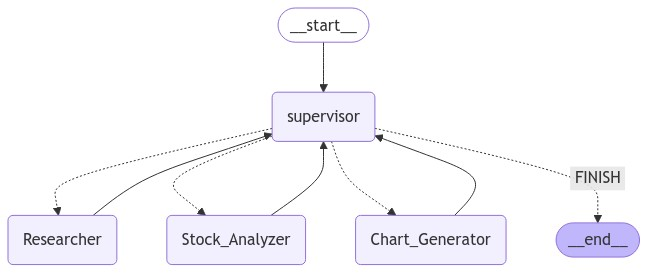

In [24]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content='테슬라(TSLA) 주식에 대한 구매 의사 결정을 돕기 위해 최신 정보를 제공하겠습니다.\n\n1. **2023년 실적**:\n   - 테슬라는 2023년 1분기와 2분기에 각각 233억 달러와 249억 달러의 매출을 기록하며 월스트리트의 예상치를 초과 달성했습니다.\n   - 연간 목표인 180만 대의 전기차(EV)를 생산할 예정이며, 이는 향후 200만 대에 이를 가능성을 보여줍니다. (출처: [The Motley Fool](https://www.fool.com/investing/2023/12/08/up-94-in-2023-is-tesla-still-a-buy/))\n\n2. **주가 전망**:\n   - 최근 테슬라 주식은 2023년에 94% 상승했으며, 2024년에도 긍정적인 전망을 받고 있습니다. 하지만 연방 세금 인센티브의 종료가 판매에 미치는 영향이 우려되고 있습니다. (출처: [The Motley Fool](https://www.fool.com/investing/2024/01/15/why-tesla-stock-surged-102-in-2023/))\n\n3. **경쟁 및 시장 동향**:\n   - 테슬라는 2023년 세계에서 가장 많이 판매된 자동차로 예상되는 모델 Y를 보유하고 있으며, 이는 120만 대 이상의 판매가 예상됩니다. 중국에서의 경쟁이 심화되고 있는 가운데, 테슬라는 Giga Shanghai에서 모델 Y의 리프레시 버전을 출시할 계획입니다. (출처: [Teslarati](https://www.teslarati.com/tesla-tsla-q4-2023-2024-predictions/))\n\n4. **애널리스트 의견**:\n   - 대부분의 애널리스트들은 테슬라가 2023년 목표인 180만 대 판매를 달성할 것으로 예상하고 있지만, 2024년에는 더 많은 도전에 직면할

Python REPL can execute arbitrary code. Use with caution.


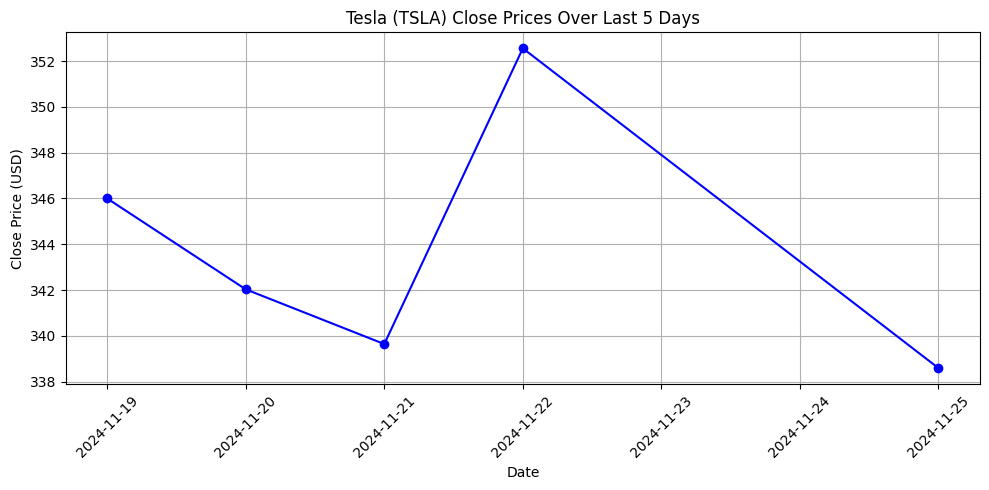

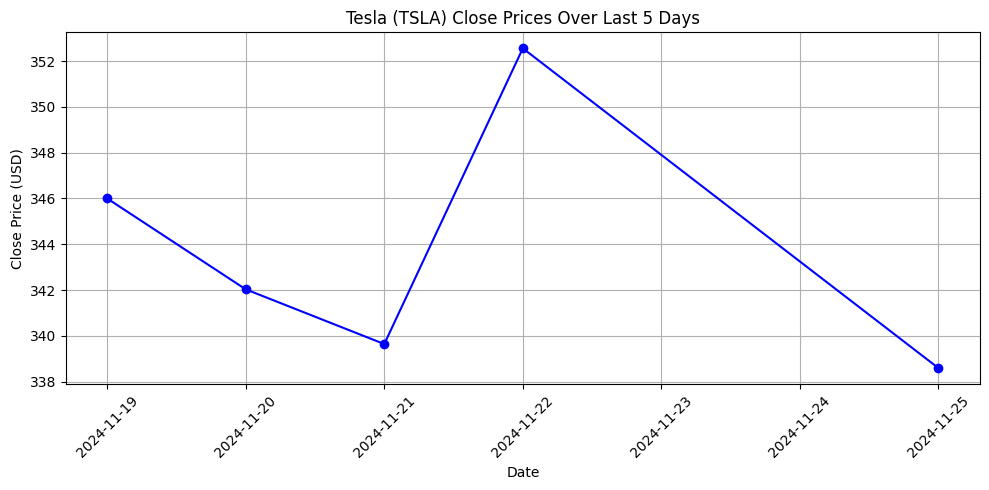

{'Chart_Generator': {'messages': [HumanMessage(content='Here is the stock chart for Tesla (TSLA) showing the close prices over the last 5 days:\n\n![Tesla (TSLA) Close Prices Over Last 5 Days](sandbox:/mnt/data/tesla_stock_chart.png) \n\nIf you need further analysis or additional information, feel free to ask!', additional_kwargs={}, response_metadata={}, name='Chart_Generator')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [25]:
for s in graph.stream({"messages": [HumanMessage(content="테슬라 주식 구매 의사 결정 도와줘")]}):
    if "__end__" not in s:
        print(s)
        print("----")